In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark") # Theme for plots as Dark
sns.set_palette("viridis")
# sns.color_palette("flare")
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool, CatBoostClassifier, cv

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv")
Test_df = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv")

test_df = Test_df.drop(columns =['id'])
train_df = train_df.drop(columns = ['id'])

In [3]:
train_df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


In [4]:
train_df.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 15  hemoglobin       

In [6]:
train_df.nunique()

age                     18
height(cm)              14
weight(kg)              28
waist(cm)              531
eyesight(left)          20
eyesight(right)         17
hearing(left)            2
hearing(right)           2
systolic               112
relaxation              75
fasting blood sugar    229
Cholesterol            227
triglyceride           392
HDL                    108
LDL                    222
hemoglobin             134
Urine protein            6
serum creatinine        28
AST                    140
ALT                    188
Gtp                    362
dental caries            2
smoking                  2
dtype: int64

In [7]:
train_df["BMI"] = train_df["weight(kg)"] / (train_df["height(cm)"]/100)**2
train_df["HDL-LDL Ratio"] = train_df["HDL"] / train_df["LDL"]
train_df["HDL-triglyceride Ratio"] = train_df["HDL"] / train_df["triglyceride"]
train_df["LDL-triglyceride Ratio"] = train_df["LDL"] / train_df["triglyceride"]
# train_df["HDL-Cholesterol Ratio"] = train_df["HDL"] / train_df["Cholesterol"]
# train_df["LDL-Cholesterol Ratio"] = train_df["LDL"] / train_df["Cholesterol"]
train_df["Liver Enzyme Ratio"] = train_df["AST"] / train_df["ALT"]

In [8]:
test_df["BMI"] = test_df["weight(kg)"] / (test_df["height(cm)"]/100)**2
test_df["HDL-LDL Ratio"] = test_df["HDL"] / test_df["LDL"]
test_df["HDL-triglyceride Ratio"] = test_df["HDL"] / test_df["triglyceride"]
test_df["LDL-triglyceride Ratio"] = test_df["LDL"] / test_df["triglyceride"]
# test_df["HDL-Cholesterol Ratio"] = test_df["HDL"] / test_df["Cholesterol"]
# test_df["LDL-Cholesterol Ratio"] = test_df["LDL"] / test_df["Cholesterol"]
test_df["Liver Enzyme Ratio"] = test_df["AST"] / test_df["ALT"]

In [9]:
train_df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,AST,ALT,Gtp,dental caries,smoking,BMI,HDL-LDL Ratio,HDL-triglyceride Ratio,LDL-triglyceride Ratio,Liver Enzyme Ratio
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,22,25,27,0,1,22.038567,0.533333,0.133333,0.250000,0.880000
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,27,23,37,1,0,23.875115,0.452381,1.036364,2.290909,1.173913
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,27,31,53,0,1,25.951557,0.483871,0.228426,0.472081,0.870968
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,20,27,30,1,0,29.320988,0.372549,0.187192,0.502463,0.740741
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,19,13,17,0,1,22.038567,0.473118,0.505747,1.068966,1.461538


<Axes: >

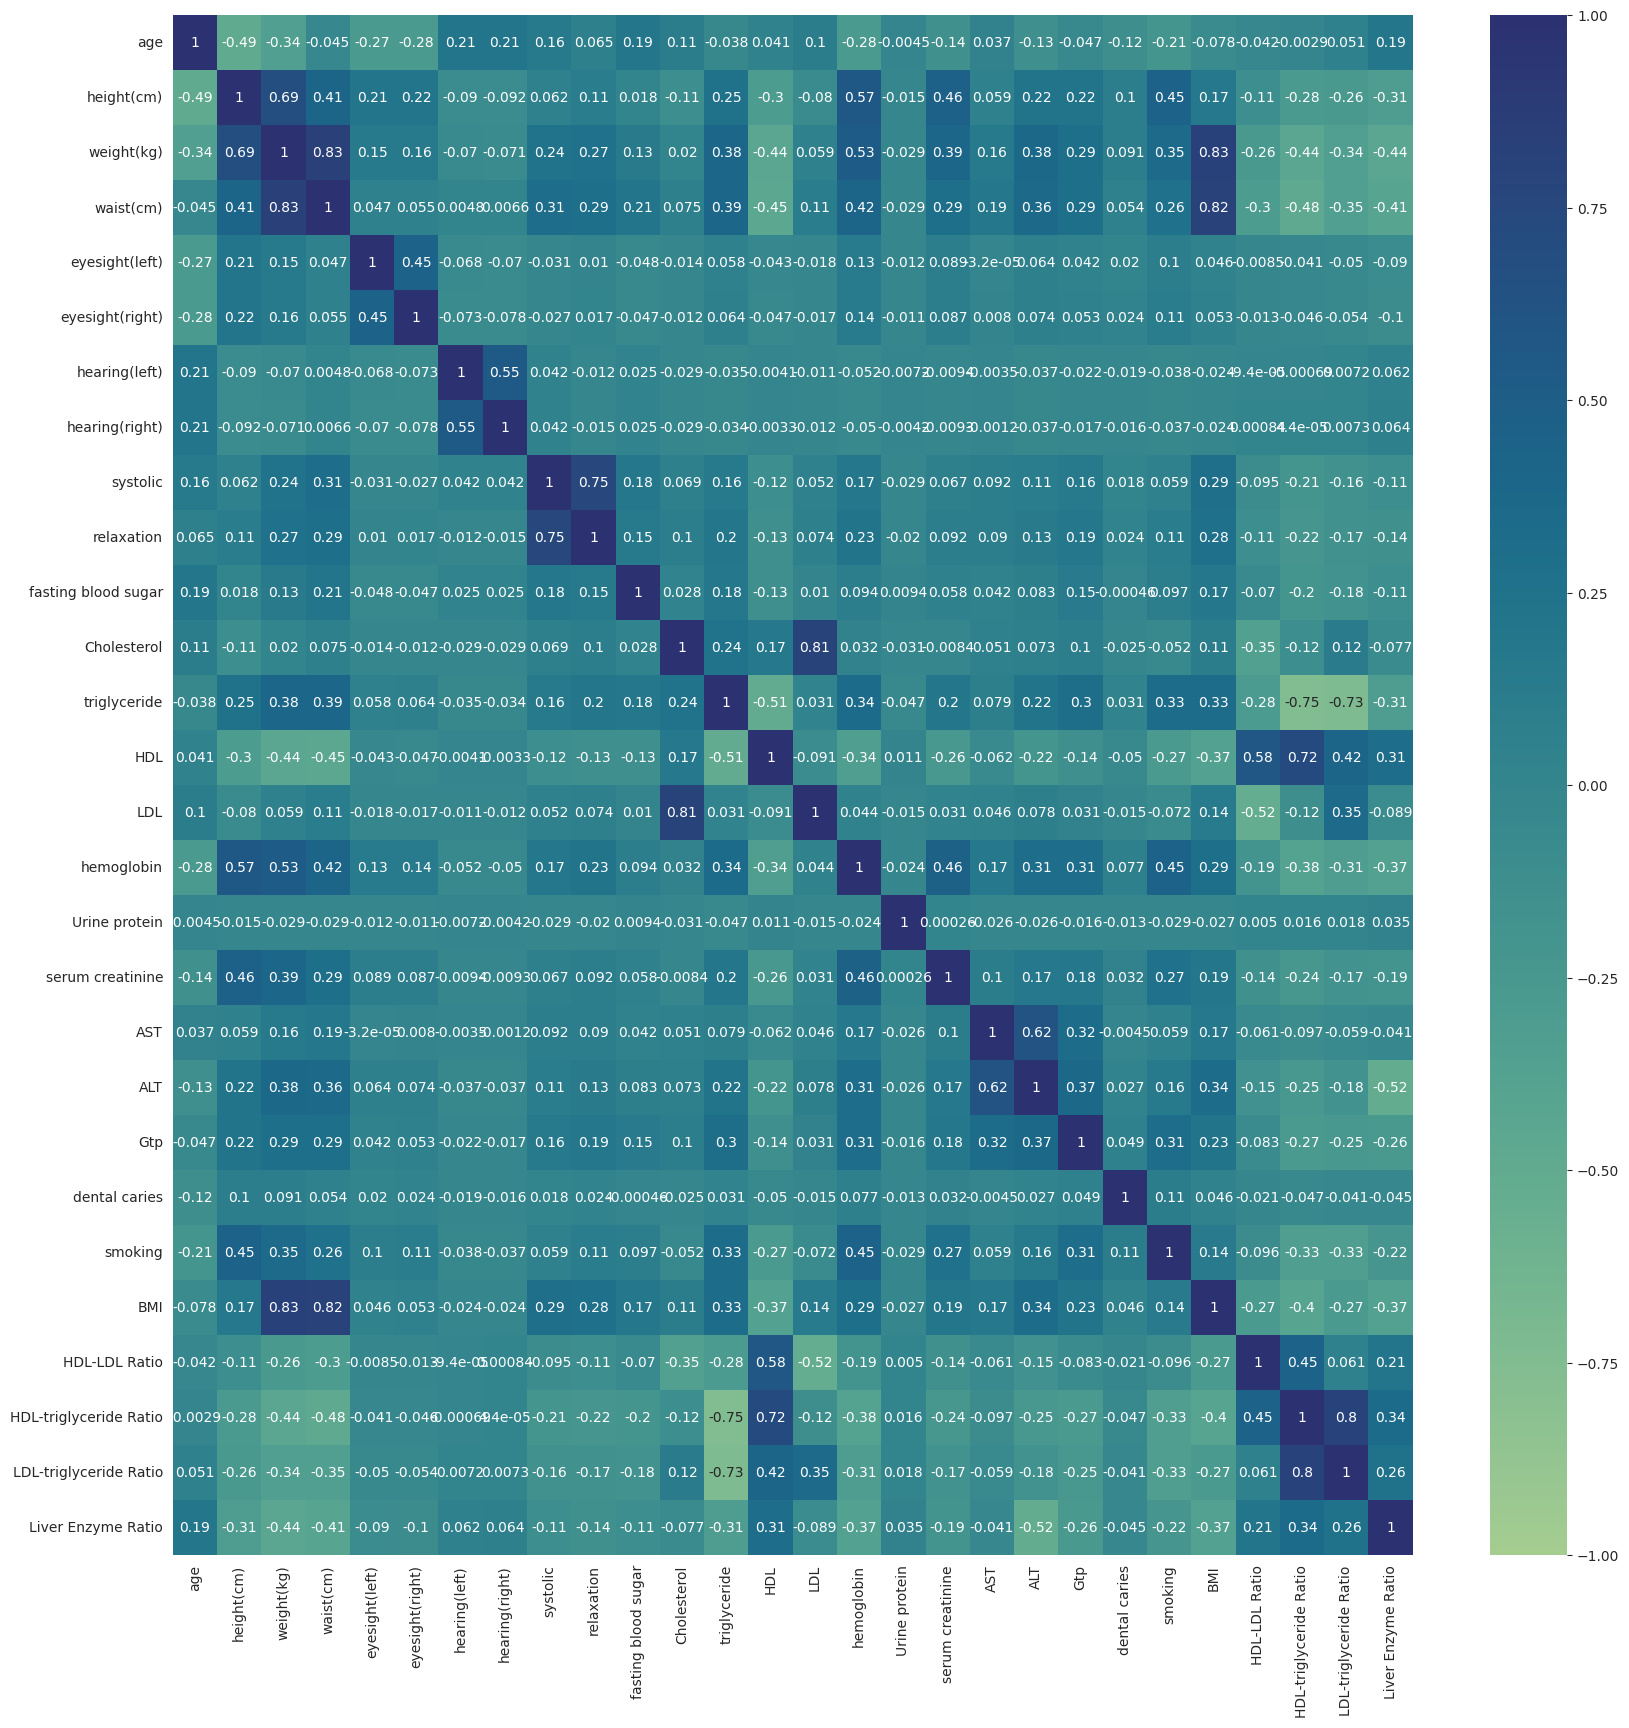

In [10]:
plt.figure(figsize =(20,20))
sns.heatmap(train_df.corr(),annot=True,cmap="crest",vmin=-1 ,vmax=1)

In [11]:
seed = np.random.seed(6)

X = train_df.drop(["smoking"],axis=1)
y = train_df["smoking"]

In [12]:
lgbmmodel = LGBMClassifier(random_state=seed, device="gpu")
print("CV score of LGBM is ",cross_val_score(lgbmmodel,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of LGBM is  0.8642750484515174


In [13]:
xgbmodel = XGBClassifier(random_state=seed, tree_method= 'gpu_hist')
print("CV score of XGB is ",cross_val_score(xgbmodel,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of XGB is  0.863872792260705


In [14]:
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',500,1000),
        "max_depth":trial.suggest_int('max_depth',3,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,250),
        "subsample" : trial.suggest_float('subsample', 0.2, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
    }
    lgbmmodel_optuna = LGBMClassifier(**params,random_state=seed,device="gpu")
    cv = cross_val_score(lgbmmodel_optuna, X, y, cv = 4,scoring='roc_auc').mean()
    return cv

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5,timeout=2000)

[I 2023-11-07 10:04:04,210] A new study created in memory with name: no-name-a4bf1e34-dbc9-42e1-b08b-797063593cf5
[I 2023-11-07 10:04:40,308] Trial 0 finished with value: 0.8587067776802791 and parameters: {'n_estimators': 706, 'max_depth': 5, 'learning_rate': 0.009377644758100618, 'min_child_weight': 0.6148498376563614, 'min_child_samples': 82, 'subsample': 0.3073323519998512, 'subsample_freq': 3, 'colsample_bytree': 0.2755751349662192, 'num_leaves': 103}. Best is trial 0 with value: 0.8587067776802791.
[I 2023-11-07 10:06:51,464] Trial 1 finished with value: 0.8510097246556515 and parameters: {'n_estimators': 978, 'max_depth': 49, 'learning_rate': 0.00032000640925509543, 'min_child_weight': 3.081292405676257, 'min_child_samples': 122, 'subsample': 0.9937615846693975, 'subsample_freq': 5, 'colsample_bytree': 0.9042727216862647, 'num_leaves': 123}. Best is trial 0 with value: 0.8587067776802791.
[I 2023-11-07 10:07:16,315] Trial 2 finished with value: 0.8431583398401379 and parameters:

In [15]:
lgbm_params = {'max_depth': 46, 'learning_rate': 0.06953273561619135,
               'min_child_weight': 2.4187716216112944, 'min_child_samples': 230, 'subsample': 0.9515130309407626,
               'subsample_freq': 4, 'colsample_bytree': 0.402284262124352, 'num_leaves': 71}

lgbm_opt = LGBMClassifier(**lgbm_params,n_estimators=624,random_state=seed,device="gpu")
print("CV score of LGBM Optuna is ",cross_val_score(lgbm_opt,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of LGBM Optuna is  0.86941693208011


In [16]:
xgb_params =   {'max_depth': 44, 'min_child_weight': 42.394074475465935,
                'learning_rate': 0.018945904767046495, 'subsample': 0.9976305222111156,
                'gamma': 0.23054785929528437, 'colsample_bytree': 0.4156956766282452,
                'colsample_bylevel': 0.9225226228188033, 'colsample_bynode': 0.686558727709571}

xgb_opt = XGBClassifier(**xgb_params,n_estimators= 727,random_state=seed,tree_method = "gpu_hist",eval_metric= "auc")
print("CV score of XGB Optuna is ",cross_val_score(xgb_opt,X,y,cv=4, scoring = 'roc_auc').mean())

CV score of XGB Optuna is  0.8695188621276302


In [17]:
Test_df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [18]:
submission = pd.DataFrame()
submission["id"] = Test_df.index
submission["smoking"] = 0

In [19]:
submission.head()

,id,smoking
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
SPLITS = 5
lgbm_auc_score = []
cat_auc_score = []
xgb_auc_score = []
denominator = 0

for i,(tr,val) in enumerate(RepeatedStratifiedKFold(n_splits=SPLITS, n_repeats=5,random_state=seed).split(X,y)):
    
    print("-"*30,"FOLD",i,"-"*30)
    X_train, X_test, y_train, y_test = X.iloc[tr,:],X.iloc[val,:],y.iloc[tr],y.iloc[val]
    
    print("\n->","LGBM:")
    lgbmmodel = LGBMClassifier(**lgbm_params,n_estimators= 5000,random_state=seed,device="gpu")
    lgbmmodel.fit(X_train,y_train, eval_set=[(X_test,y_test)], eval_names=["valid"],eval_metric=['auc'], early_stopping_rounds=250,verbose = 250)
    auc = roc_auc_score(y_test, lgbmmodel.predict_proba(X_test)[:,1])
    lgbm_auc_score.append(auc)
    print(f"\nFold {i} ROC_AUC of LGBM =", auc,"\n")
    if auc>=0.87:
        denominator+=1
        submission["smoking"] += lgbmmodel.predict_proba(test_df)[:,1]
    
    print("\n->","CAT:")
    train_dataset = Pool(data=X.iloc[tr,:],label=y.iloc[tr])
    eval_dataset = Pool(data=X.iloc[val,:],label=y.iloc[val])
    
    catmodel = CatBoostClassifier(iterations=5000,verbose=250, od_type="Iter",eval_metric="AUC", random_seed=seed,early_stopping_rounds=250)
    catmodel.fit(train_dataset, use_best_model=True, eval_set=eval_dataset)
    auc = roc_auc_score(y.iloc[val], catmodel.predict_proba(X.iloc[val,:])[:,1])
    cat_auc_score.append(auc)
    if auc>=0.87:
        denominator+=1
        submission["smoking"] += catmodel.predict_proba(test_df)[:,1]
    
    print("\n->","XGB:")
    xgbmodel = XGBClassifier(**xgb_params,n_estimators= 5000,random_state=seed, tree_method= 'gpu_hist',eval_metric="auc",early_stopping_rounds = 250)
    xgbmodel.fit(X_train,y_train, eval_set=[(X_test,y_test)],verbose = 250,callbacks=[EarlyStopping(rounds = 250,save_best=True)])
    
    auc = roc_auc_score(y_test, xgbmodel.predict_proba(X_test)[:,1])
    xgb_auc_score.append(auc)
    print(f"\nFold {i} ROC_AUC of XGB =", auc,"\n")
    if auc>=0.87:
        denominator+=1
        submission["smoking"] += xgbmodel.predict_proba(test_df)[:,1]
    
print("\n\n","-"*50,sep="")
print("CV score of LGBM is ",np.array(lgbm_auc_score).mean())
print("CV score of CAT is ",np.array(cat_auc_score).mean())
print("CV score of XGB is ",np.array(xgb_auc_score).mean())

------------------------------ FOLD 0 ------------------------------

-> LGBM:
[250]	valid's auc: 0.869377	valid's binary_logloss: 0.437527
[500]	valid's auc: 0.870431	valid's binary_logloss: 0.436314

Fold 0 ROC_AUC of LGBM = 0.870477737113482 


-> CAT:
Learning rate set to 0.0521
0:	test: 0.8259096	best: 0.8259096 (0)	total: 82.5ms	remaining: 6m 52s
250:	test: 0.8628196	best: 0.8628196 (250)	total: 6.38s	remaining: 2m
500:	test: 0.8655510	best: 0.8655510 (500)	total: 12.5s	remaining: 1m 51s
750:	test: 0.8668353	best: 0.8668353 (750)	total: 18.9s	remaining: 1m 46s
1000:	test: 0.8674653	best: 0.8674695 (999)	total: 25s	remaining: 1m 39s
1250:	test: 0.8681355	best: 0.8681499 (1217)	total: 31.1s	remaining: 1m 33s
1500:	test: 0.8684606	best: 0.8684632 (1499)	total: 37.2s	remaining: 1m 26s
1750:	test: 0.8686324	best: 0.8686389 (1733)	total: 43.4s	remaining: 1m 20s
2000:	test: 0.8687312	best: 0.8687312 (2000)	total: 50s	remaining: 1m 14s
2250:	test: 0.8689173	best: 0.8689268 (2233)	total: 

In [ ]:
def plotImportance(modelNames,models):
    plt.subplots(len(modelNames),1,figsize=(14,5*len(modelNames)),dpi=300)
    for ind,modelName in enumerate(modelNames):
        history = pd.DataFrame()
        history["cols"] = X_test.columns
        if modelNames[ind] == "CatBoost":
            history["imp"] = models[ind].get_feature_importance()
        else:  
            history["imp"] = models[ind].feature_importances_
        history.sort_values("imp",inplace=True,ascending=False)
        history.reset_index(drop=True)
        plt.subplot(len(modelNames),1,ind+1)
        sns.barplot(x=history["imp"],y=history["cols"],palette="rocket");
        plt.title("Feature Imporance of "+modelName)

In [ ]:
plotImportance(["LGBM","XGB","CatBoost"],[lgbmmodel,xgbmodel,catmodel])


In [ ]:
submission.head()

In [ ]:
submission["smoking"] = submission["smoking"]/denominator
submission.head(10)

In [ ]:


































































































submission[["id","smoking"]].to_csv("submission1.csv",header=True,index=False)